In [261]:
!git clone -b dev-rose https://github.com/Finweto/Projet-deep-learning-2022.git

fatal: destination path 'Projet-deep-learning-2022' already exists and is not an empty directory.


In [262]:
# Imports
import itertools
import os
import pathlib
import random
import typing

import csv
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn
import sklearn.utils
import sklearn.metrics
import tensorflow as tf
import tensorflow.keras as keras

In [263]:
################################################ Paramètres GLOBAUX ############################################
nodes = 15   # Number of nodes in the simple models
l_rate = 0.0001   # Learning rate
ep = 30    # Epochs

#                                                     MODELE 1 : Bords lisses ou dentés

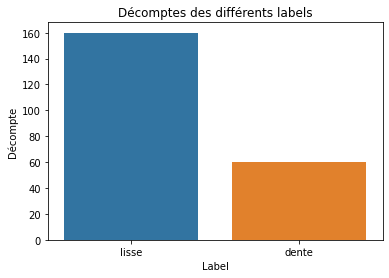

In [264]:
################################################ MODELE 1 : BORDS ##############################################

## CHOIX DE LA FEATURE :
label_names = ["dente", "lisse"] # Le 2ème élement du tableau sera celui converti en "1", le premier sera converti en 0
feature = "bord"



# Récupération des données préparées
data_train_labeled=pd.read_csv('Projet-deep-learning-2022/data_train_labeled.csv')



def get_images(filename):

  df=pd.read_csv(filename)
  images = []
  labels = []

  for i in range(len(df[feature])):
    path=df["img_path"][i]

    image=cv2.imread("Projet-deep-learning-2022/"+path)
    image=cv2.resize(image,(150,150))
    images.append(image)

    label=df[feature][i]
    ########## On convertit la réponse binaire en valeur numérique
    if df[feature][i]==label_names[1]:
      label = 1
    else:
      label = 0
    
    labels.append(label)

    # Mélange des tableaux
    images, labels = sklearn.utils.shuffle(images, labels)

  return images,labels



images, labels= get_images("Projet-deep-learning-2022/data_train_labeled.csv")

seaborn.countplot(x=data_train_labeled[feature])
plt.title("Décomptes des différents labels")
plt.ylabel("Décompte")
plt.xlabel("Label")
plt.show()

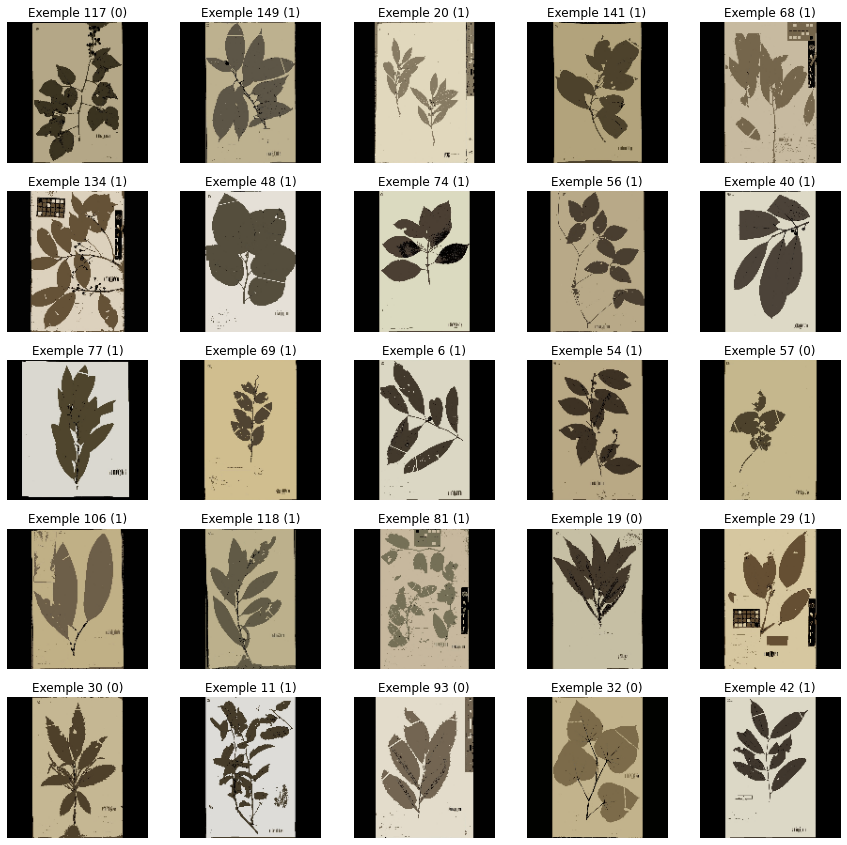

In [265]:
## Affichage des données originales

f, ax = plt.subplots(5, 5, figsize=(15, 15))
random_indexes = np.random.choice(images[0].shape[0], size=(5, 5), replace=False)

for i in range(5):
  for j in range(5):
    img_index = random_indexes[i, j]
    image = images[img_index]
    label = labels[img_index]

    ax[i, j].imshow(image)
    ax[i, j].set_title(f"Exemple {img_index} ({label})")
    ax[i, j].axis('off')

In [266]:
################################################ CONSTRUCTION DU MODELE ########################################

## Version COMPLEXE (fait de l'overfitting)

conv2d_params = dict(kernel_size=(3,3), activation="relu", kernel_initializer="orthogonal", padding="same")
dense_params = dict(activation="relu", kernel_initializer="orthogonal")


model = keras.models.Sequential()
model.add(keras.layers.Conv2D(200, input_shape=(150, 150, 3), **conv2d_params))
model.add(keras.layers.MaxPool2D(2, 2, padding="same"))
model.add(keras.layers.Conv2D(200, **conv2d_params))
model.add(keras.layers.MaxPool2D(2, 2, padding="same"))
model.add(keras.layers.Conv2D(200, **conv2d_params))
model.add(keras.layers.MaxPool2D(2, 2, padding="same"))
model.add(keras.layers.Conv2D(200, **conv2d_params))
model.add(keras.layers.MaxPool2D(2, 2, padding="same"))
model.add(keras.layers.Conv2D(200, **conv2d_params))
model.add(keras.layers.MaxPool2D(2, 2, padding="same"))
model.add(keras.layers.Conv2D(200, **conv2d_params))
model.add(keras.layers.MaxPool2D(2, 2, padding="same"))
model.add(keras.layers.Conv2D(200, **conv2d_params))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(200, **dense_params))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(100, **dense_params))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(50, **dense_params))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(11,
                             activation="softmax",
                             kernel_initializer="orthogonal"))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])


#model.summary()

In [267]:
## Version SIMPLE

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(nodes,
                              kernel_size=(3, 3),
                              activation="relu",
                              input_shape=(150, 150, 3)))
model.add(keras.layers.MaxPool2D(3,3))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(nodes, activation="softmax"))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=l_rate),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

#model.summary()

Epoch 1/30
2/2 [==============================] - 1s 174ms/step - loss: 286.4562 - accuracy: 0.0455 - val_loss: 59.3100 - val_accuracy: 0.3182
Epoch 2/30
2/2 [==============================] - 0s 35ms/step - loss: 60.0929 - accuracy: 0.3831 - val_loss: 87.5813 - val_accuracy: 0.6818
Epoch 3/30
2/2 [==============================] - 0s 41ms/step - loss: 81.6251 - accuracy: 0.7468 - val_loss: 137.0452 - val_accuracy: 0.6818
Epoch 4/30
2/2 [==============================] - 0s 37ms/step - loss: 118.3722 - accuracy: 0.7468 - val_loss: 143.0222 - val_accuracy: 0.6818
Epoch 5/30
2/2 [==============================] - 0s 35ms/step - loss: 120.6502 - accuracy: 0.7468 - val_loss: 119.7041 - val_accuracy: 0.6818
Epoch 6/30
2/2 [==============================] - 0s 35ms/step - loss: 98.3212 - accuracy: 0.7468 - val_loss: 73.1525 - val_accuracy: 0.6818
Epoch 7/30
2/2 [==============================] - 0s 38ms/step - loss: 57.1218 - accuracy: 0.7468 - val_loss: 12.2714 - val_accuracy: 0.6970
Epoch 

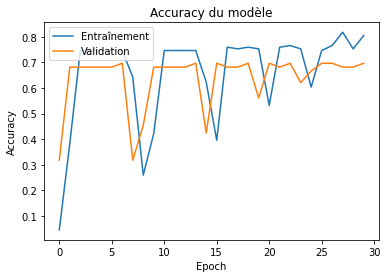

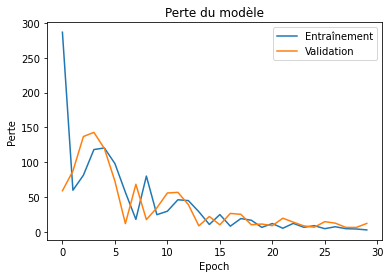

In [268]:
################################################ APPRENTISSAGE ########################################

# Apprentissage du modèle
images=np.array(images)
labels=np.array(labels)


training = model.fit(images, labels, epochs=ep, batch_size=128, validation_split=0.30)


# Visualisation des métriques d'entrainement
def plot_metrics(history) -> None:
  plt.plot(training.history["accuracy"])
  plt.plot(training.history["val_accuracy"])
  plt.title("Accuracy du modèle")
  plt.ylabel("Accuracy")
  plt.xlabel("Epoch")
  plt.legend(["Entraînement", "Validation"], loc="upper left")
  plt.show()

  plt.plot(training.history["loss"])
  plt.plot(training.history["val_loss"])
  plt.title("Perte du modèle")
  plt.ylabel("Perte")
  plt.xlabel("Epoch")
  plt.legend(["Entraînement", "Validation"], loc="upper right")
  plt.show()


plot_metrics(training.history)

In [269]:
## Evaluation du modèle
test_images, test_labels = get_images("Projet-deep-learning-2022/data_test_labeled.csv")
model.evaluate(np.array(test_images), np.array(test_labels), verbose=1)

4/4 [==============================] - 0s 5ms/step - loss: 18.1774 - accuracy: 0.7182


[18.17740821838379, 0.7181817889213562]

4/4 [==============================] - 0s 4ms/step


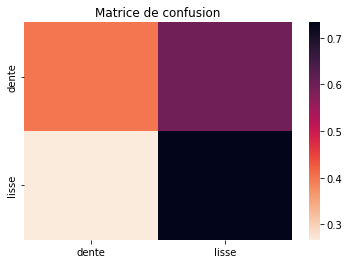

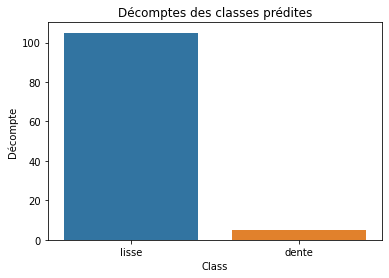

In [270]:
## Analyse des erreurs

def analyze_preds(preds, labels):
  confusion_matrix = sklearn.metrics.confusion_matrix(preds,
                                                      labels,
                                                      normalize="true")
  seaborn.heatmap(confusion_matrix,
                  cmap="rocket_r",
                  xticklabels=label_names,
                  yticklabels=label_names)
  plt.title("Matrice de confusion")
  plt.show()

  seaborn.countplot(x=list(map(lambda x: label_names[x], preds)))
  plt.title("Décomptes des classes prédites")
  plt.ylabel("Décompte")
  plt.xlabel("Class")
  plt.show()


test_pred = np.argmax(model.predict(np.array(test_images)), axis=-1)
analyze_preds(test_pred, test_labels)

Prédiction : 1, classe réelle : 0


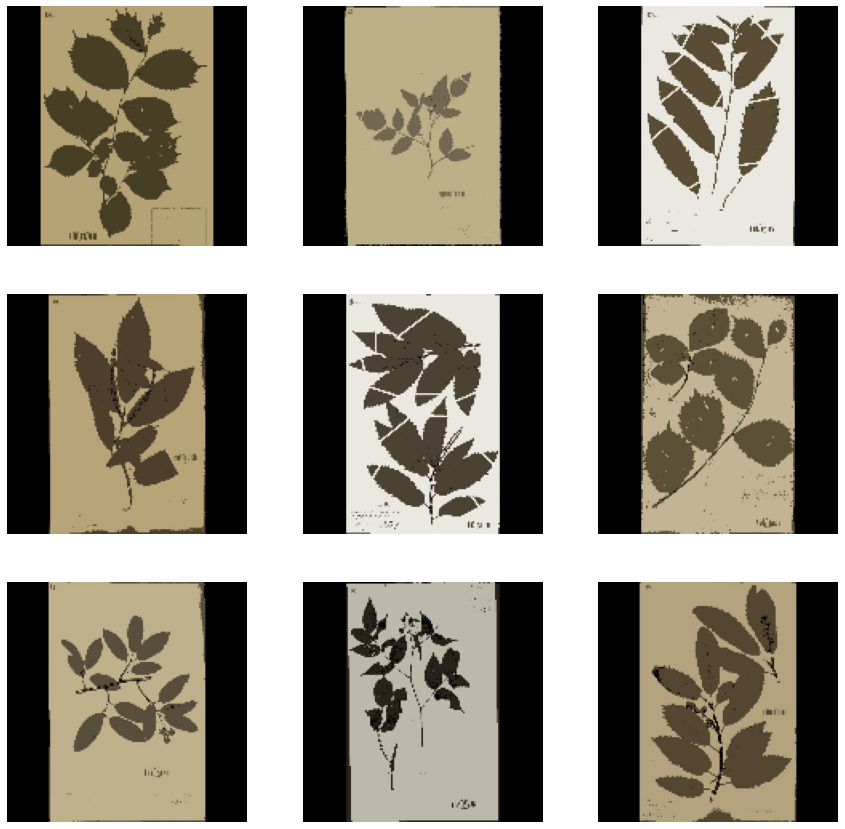

Valeurs prédites par notre modèle :
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1]

Valeurs réelles :
[1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1]


In [271]:
def plot_mistakes(predicted_class: str, true_class: str) -> None:
  print(f"Prédiction : {predicted_class}, classe réelle : {true_class}")
  mistakes=[]

  for index, image in enumerate(test_images):
    if (test_pred[index] == predicted_class) and (test_labels[index] == true_class):
      mistakes.append(image)
  

  random_indexes = np.random.choice(len(mistakes),
                                       size=min(len(mistakes), 9),
                                       replace=False)
  grid_indexes = itertools.product(range(3), repeat=2)

  _, ax = plt.subplots(3, 3, figsize=(15, 15))
  for img_index, (i, j) in zip(random_indexes, grid_indexes):
    ax[i, j].imshow(mistakes[img_index])
    ax[i, j].axis("off")
  plt.show()
  

# On plot quelques unes des images prédites lisses (=1) alors qu'elles sont dentées (=0)
plot_mistakes(1, 0)
print("Valeurs prédites par notre modèle :")
print(test_pred)
print("\nValeurs réelles :")
print(test_labels)

#                                                      MODELE 2 : Phyllotaxie

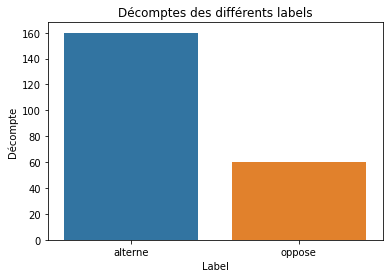

In [272]:
################################################ MODELE 2 : Phyllotaxie ##############################################

## CHOIX DE LA FEATURE :
label_names = ["oppose", "alterne"] # Le 2ème élement du tableau sera celui converti en "1", le premier sera converti en 0
feature = "phyllotaxie"



# Récupération des données préparées
data_train_labeled=pd.read_csv('Projet-deep-learning-2022/data_train_labeled.csv')



def get_images(filename):

  df=pd.read_csv(filename)
  images = []
  labels = []

  for i in range(len(df[feature])):
    path=df["img_path"][i]

    image=cv2.imread("Projet-deep-learning-2022/"+path)
    image=cv2.resize(image,(150,150))
    images.append(image)

    label=df[feature][i]
    ########## On convertit la réponse binaire en valeur numérique
    if df[feature][i]==label_names[1]:
      label = 1
    else:
      label = 0
    
    labels.append(label)

    # Mélange des tableaux
    images, labels = sklearn.utils.shuffle(images, labels)

  return images,labels



images, labels= get_images("Projet-deep-learning-2022/data_train_labeled.csv")

seaborn.countplot(x=data_train_labeled[feature])
plt.title("Décomptes des différents labels")
plt.ylabel("Décompte")
plt.xlabel("Label")
plt.show()

In [273]:
################################################ CONSTRUCTION DU MODELE ########################################


## Modèle version SIMPLE

model2 = keras.models.Sequential()
model2.add(keras.layers.Conv2D(nodes,
                              kernel_size=(3, 3),
                              activation="relu",
                              input_shape=(150, 150, 3)))
model2.add(keras.layers.MaxPool2D(3,3))
model2.add(keras.layers.Flatten())
model2.add(keras.layers.Dense(nodes, activation="softmax"))
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=l_rate),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

#model2.summary()

Epoch 1/40
2/2 [==============================] - 1s 176ms/step - loss: 36.6154 - accuracy: 0.1688 - val_loss: 5.8040 - val_accuracy: 0.6515
Epoch 2/40
2/2 [==============================] - 0s 35ms/step - loss: 7.6972 - accuracy: 0.6234 - val_loss: 7.1391 - val_accuracy: 0.4697
Epoch 3/40
2/2 [==============================] - 0s 38ms/step - loss: 6.6641 - accuracy: 0.5130 - val_loss: 11.5990 - val_accuracy: 0.7273
Epoch 4/40
2/2 [==============================] - 0s 47ms/step - loss: 9.9657 - accuracy: 0.7273 - val_loss: 6.3092 - val_accuracy: 0.6818
Epoch 5/40
2/2 [==============================] - 0s 36ms/step - loss: 4.2874 - accuracy: 0.7273 - val_loss: 10.5833 - val_accuracy: 0.4091
Epoch 6/40
2/2 [==============================] - 0s 35ms/step - loss: 6.4410 - accuracy: 0.5455 - val_loss: 6.7658 - val_accuracy: 0.5909
Epoch 7/40
2/2 [==============================] - 0s 34ms/step - loss: 3.2508 - accuracy: 0.7597 - val_loss: 8.1655 - val_accuracy: 0.6970
Epoch 8/40
2/2 [=======

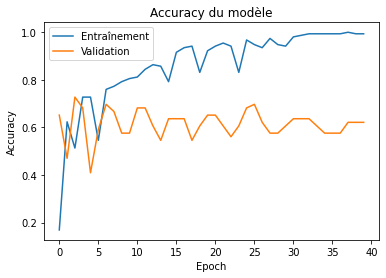

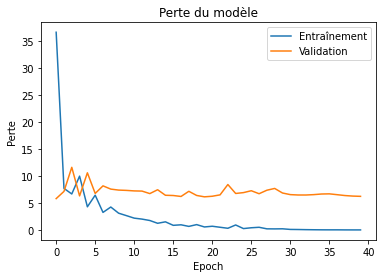

In [274]:
################################################ APPRENTISSAGE ########################################

# Apprentissage du modèle
images=np.array(images)
labels=np.array(labels)


training2 = model2.fit(images, labels, epochs=ep+10, batch_size=128, validation_split=0.30)


# Visualisation des métriques d'entrainement
def plot_metrics(history) -> None:
  plt.plot(training2.history["accuracy"])
  plt.plot(training2.history["val_accuracy"])
  plt.title("Accuracy du modèle")
  plt.ylabel("Accuracy")
  plt.xlabel("Epoch")
  plt.legend(["Entraînement", "Validation"], loc="upper left")
  plt.show()

  plt.plot(training2.history["loss"])
  plt.plot(training2.history["val_loss"])
  plt.title("Perte du modèle")
  plt.ylabel("Perte")
  plt.xlabel("Epoch")
  plt.legend(["Entraînement", "Validation"], loc="upper right")
  plt.show()


plot_metrics(training2.history)

In [275]:
## Evaluation du modèle
test_images, test_labels = get_images("Projet-deep-learning-2022/data_test_labeled.csv")
model2.evaluate(np.array(test_images), np.array(test_labels), verbose=1)

4/4 [==============================] - 0s 6ms/step - loss: 5.5174 - accuracy: 0.6000


[5.517355442047119, 0.6000000238418579]

4/4 [==============================] - 0s 4ms/step


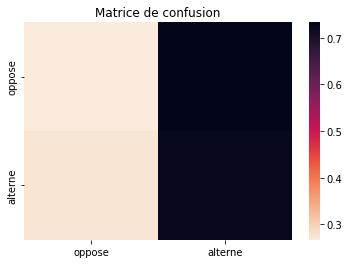

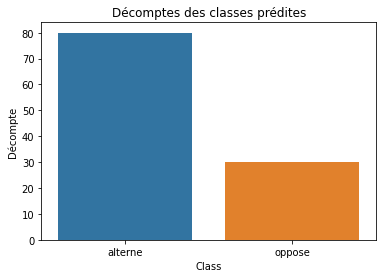

In [276]:
## Analyse des erreurs

def analyze_preds(preds, labels):
  confusion_matrix = sklearn.metrics.confusion_matrix(preds,
                                                      labels,
                                                      normalize="true")
  seaborn.heatmap(confusion_matrix,
                  cmap="rocket_r",
                  xticklabels=label_names,
                  yticklabels=label_names)
  plt.title("Matrice de confusion")
  plt.show()

  seaborn.countplot(x=list(map(lambda x: label_names[x], preds)))
  plt.title("Décomptes des classes prédites")
  plt.ylabel("Décompte")
  plt.xlabel("Class")
  plt.show()


test_pred = np.argmax(model2.predict(np.array(test_images)), axis=-1)
analyze_preds(test_pred, test_labels)

#                                                      MODELE 3 : Type de feuille

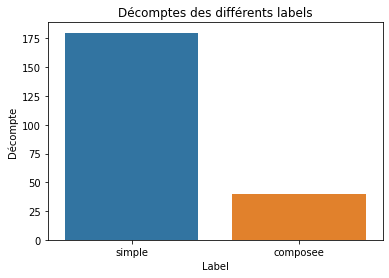

In [277]:
################################################ MODELE 3 : Type de feuille ##############################################

## CHOIX DE LA FEATURE :
label_names = ["composee", "simple"] # Le 2ème élement du tableau sera celui converti en "1", le premier sera converti en 0
feature = "type_feuille"



# Récupération des données préparées
data_train_labeled=pd.read_csv('Projet-deep-learning-2022/data_train_labeled.csv')



def get_images(filename):

  df=pd.read_csv(filename)
  images = []
  labels = []

  for i in range(len(df[feature])):
    path=df["img_path"][i]

    image=cv2.imread("Projet-deep-learning-2022/"+path)
    image=cv2.resize(image,(150,150))
    images.append(image)

    label=df[feature][i]
    ########## On convertit la réponse binaire en valeur numérique
    if df[feature][i]==label_names[1]:
      label = 1
    else:
      label = 0
    
    labels.append(label)

    # Mélange des tableaux
    images, labels = sklearn.utils.shuffle(images, labels)

  return images,labels



images, labels= get_images("Projet-deep-learning-2022/data_train_labeled.csv")

seaborn.countplot(x=data_train_labeled[feature])
plt.title("Décomptes des différents labels")
plt.ylabel("Décompte")
plt.xlabel("Label")
plt.show()

In [278]:
################################################ CONSTRUCTION DU MODELE ########################################


## Modèle version SIMPLE

model3 = keras.models.Sequential()
model3.add(keras.layers.Conv2D(nodes,
                              kernel_size=(3, 3),
                              activation="relu",
                              input_shape=(150, 150, 3)))
model3.add(keras.layers.MaxPool2D(3,3))
model3.add(keras.layers.Flatten())
model3.add(keras.layers.Dense(nodes, activation="softmax"))
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=l_rate),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

#model3.summary()

Epoch 1/40
2/2 [==============================] - 0s 167ms/step - loss: 110.7985 - accuracy: 0.0260 - val_loss: 10.6051 - val_accuracy: 0.7727
Epoch 2/40
2/2 [==============================] - 0s 38ms/step - loss: 12.4090 - accuracy: 0.7857 - val_loss: 37.1718 - val_accuracy: 0.8182
Epoch 3/40
2/2 [==============================] - 0s 34ms/step - loss: 37.4639 - accuracy: 0.8182 - val_loss: 45.8363 - val_accuracy: 0.8182
Epoch 4/40
2/2 [==============================] - 0s 38ms/step - loss: 46.2463 - accuracy: 0.8182 - val_loss: 44.5290 - val_accuracy: 0.8182
Epoch 5/40
2/2 [==============================] - 0s 43ms/step - loss: 44.1668 - accuracy: 0.8182 - val_loss: 35.5761 - val_accuracy: 0.8182
Epoch 6/40
2/2 [==============================] - 0s 37ms/step - loss: 33.7828 - accuracy: 0.8182 - val_loss: 20.7843 - val_accuracy: 0.8182
Epoch 7/40
2/2 [==============================] - 0s 34ms/step - loss: 17.6978 - accuracy: 0.8182 - val_loss: 8.8926 - val_accuracy: 0.6667
Epoch 8/40
2

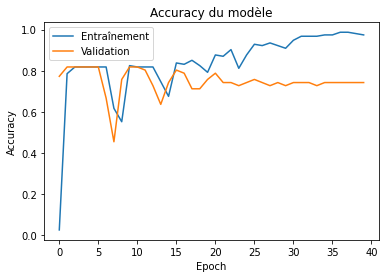

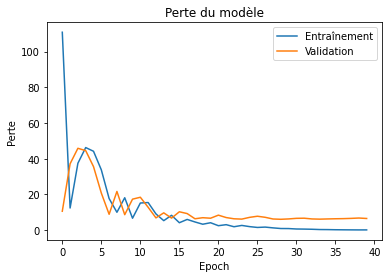

In [279]:
################################################ APPRENTISSAGE ########################################

# Apprentissage du modèle
images=np.array(images)
labels=np.array(labels)


training3 = model3.fit(images, labels, epochs=ep+10, batch_size=128, validation_split=0.30)


# Visualisation des métriques d'entrainement
def plot_metrics(history) -> None:
  plt.plot(training3.history["accuracy"])
  plt.plot(training3.history["val_accuracy"])
  plt.title("Accuracy du modèle")
  plt.ylabel("Accuracy")
  plt.xlabel("Epoch")
  plt.legend(["Entraînement", "Validation"], loc="upper left")
  plt.show()

  plt.plot(training3.history["loss"])
  plt.plot(training3.history["val_loss"])
  plt.title("Perte du modèle")
  plt.ylabel("Perte")
  plt.xlabel("Epoch")
  plt.legend(["Entraînement", "Validation"], loc="upper right")
  plt.show()


plot_metrics(training3.history)

In [280]:
## Evaluation du modèle
test_images, test_labels = get_images("Projet-deep-learning-2022/data_test_labeled.csv")
model3.evaluate(np.array(test_images), np.array(test_labels), verbose=1)

4/4 [==============================] - 0s 7ms/step - loss: 6.7293 - accuracy: 0.7364


[6.729315757751465, 0.7363636493682861]

4/4 [==============================] - 0s 4ms/step


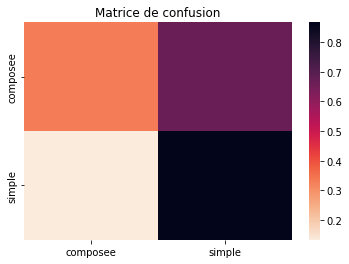

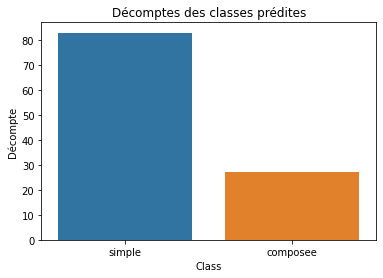

In [281]:
## Analyse des erreurs

def analyze_preds(preds, labels):
  confusion_matrix = sklearn.metrics.confusion_matrix(preds,
                                                      labels,
                                                      normalize="true")
  seaborn.heatmap(confusion_matrix,
                  cmap="rocket_r",
                  xticklabels=label_names,
                  yticklabels=label_names)
  plt.title("Matrice de confusion")
  plt.show()

  seaborn.countplot(x=list(map(lambda x: label_names[x], preds)))
  plt.title("Décomptes des classes prédites")
  plt.ylabel("Décompte")
  plt.xlabel("Class")
  plt.show()


test_pred = np.argmax(model3.predict(np.array(test_images)), axis=-1)
analyze_preds(test_pred, test_labels)

  #  MODELE 4 : Ligneux

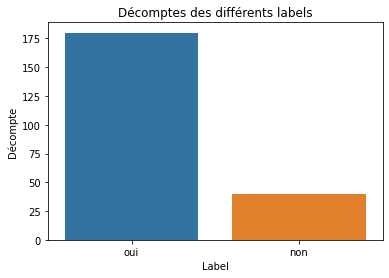

In [282]:
################################################ MODELE 4 : Feuille ligneuse ##############################################

## CHOIX DE LA FEATURE :
label_names = ["non", "oui"] # Le 2ème élement du tableau sera celui converti en "1", le premier sera converti en 0
feature = "ligneux"



# Récupération des données préparées
data_train_labeled=pd.read_csv('Projet-deep-learning-2022/data_train_labeled.csv')



def get_images(filename):

  df=pd.read_csv(filename)
  images = []
  labels = []

  for i in range(len(df[feature])):
    path=df["img_path"][i]

    image=cv2.imread("Projet-deep-learning-2022/"+path)
    image=cv2.resize(image,(150,150))
    images.append(image)

    label=df[feature][i]
    ########## On convertit la réponse binaire en valeur numérique
    if df[feature][i]==label_names[1]:
      label = 1
    else:
      label = 0
    
    labels.append(label)

    # Mélange des tableaux
    images, labels = sklearn.utils.shuffle(images, labels)

  return images,labels


images, labels= get_images("Projet-deep-learning-2022/data_train_labeled.csv")

seaborn.countplot(x=data_train_labeled[feature])
plt.title("Décomptes des différents labels")
plt.ylabel("Décompte")
plt.xlabel("Label")
plt.show()


from sklearn.model_selection import train_test_split
images, images_validation, labels, labels_validation = train_test_split(images, labels, stratify=labels, test_size=0.3) # before model building

In [283]:
## Version COMPLEXE (fait de l'overfitting)

from keras import layers as layer
model4 = keras.models.Sequential()
model4.add(layer.Conv2D(128,3,activation='relu',input_shape=(150,150,3)))
model4.add(layer.Conv2D(64,3,activation='relu'))
model4.add(layer.Conv2D(32,3,activation='relu'))
model4.add(layer.MaxPooling2D(3))
model4.add(layer.Dropout(0.2))

model4.add(layer.Conv2D(128,3,activation='relu'))
model4.add(layer.Conv2D(64,3,activation='relu'))
model4.add(layer.Conv2D(32,3,activation='relu'))
model4.add(layer.MaxPooling2D(3))
model4.add(layer.Dropout(0.2))

model4.add(layer.Conv2D(128,3,activation='relu'))
model4.add(layer.Conv2D(64,3,activation='relu'))
model4.add(layer.Conv2D(32,3,activation='relu'))
model4.add(layer.MaxPooling2D(3))
model4.add(layer.Dropout(0.2))

model4.add(layer.Flatten())

model4.add(layer.Dense(512, activation='relu'))
model4.add(layer.Dropout(0.4))

model4.add(layer.Dense(11, activation="softmax"))

# Compilation du modèle
model4.compile(
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy'],
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
)


In [284]:
################################################ CONSTRUCTION DU MODELE ########################################


## Modèle version SIMPLE

model4 = keras.models.Sequential()
model4.add(keras.layers.Conv2D(nodes,
                              kernel_size=(3, 3),
                              activation="relu",
                              input_shape=(150, 150, 3)))
model4.add(keras.layers.MaxPool2D(3,3))
model4.add(keras.layers.Flatten())
model4.add(keras.layers.Dense(nodes, activation="softmax"))
model4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=l_rate),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

#model4.summary()

Epoch 1/30
1/1 [==============================] - 1s 503ms/step - loss: 48.0273 - accuracy: 0.0467 - val_loss: 16.9995 - val_accuracy: 0.7447
Epoch 2/30
1/1 [==============================] - 0s 54ms/step - loss: 10.0472 - accuracy: 0.8411 - val_loss: 9.9718 - val_accuracy: 0.7872
Epoch 3/30
1/1 [==============================] - 0s 52ms/step - loss: 8.1668 - accuracy: 0.6168 - val_loss: 11.1597 - val_accuracy: 0.7660
Epoch 4/30
1/1 [==============================] - 0s 53ms/step - loss: 6.5302 - accuracy: 0.7944 - val_loss: 10.3397 - val_accuracy: 0.8085
Epoch 5/30
1/1 [==============================] - 0s 57ms/step - loss: 5.7191 - accuracy: 0.7944 - val_loss: 7.9618 - val_accuracy: 0.7660
Epoch 6/30
1/1 [==============================] - 0s 51ms/step - loss: 5.2308 - accuracy: 0.6636 - val_loss: 10.4046 - val_accuracy: 0.7872
Epoch 7/30
1/1 [==============================] - 0s 73ms/step - loss: 4.7043 - accuracy: 0.8318 - val_loss: 9.1913 - val_accuracy: 0.8085
Epoch 8/30
1/1 [====

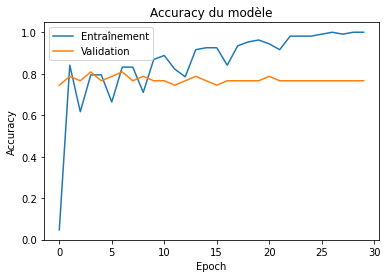

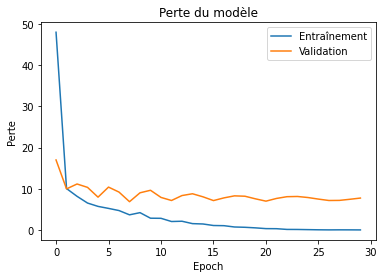

In [285]:
################################################ APPRENTISSAGE ########################################

# Apprentissage du modèle
images=np.array(images)
labels=np.array(labels)
images_validation=np.array(images_validation)
labels_validation=np.array(labels_validation)


training4 = model4.fit(images, labels, epochs=ep, batch_size=128, validation_split=0.30) #, validation_data=(images_validation, labels_validation))


# Visualisation des métriques d'entrainement
def plot_metrics(history) -> None:
  plt.plot(training4.history["accuracy"])
  plt.plot(training4.history["val_accuracy"])
  plt.title("Accuracy du modèle")
  plt.ylabel("Accuracy")
  plt.xlabel("Epoch")
  plt.legend(["Entraînement", "Validation"], loc="upper left")
  plt.show()

  plt.plot(training4.history["loss"])
  plt.plot(training4.history["val_loss"])
  plt.title("Perte du modèle")
  plt.ylabel("Perte")
  plt.xlabel("Epoch")
  plt.legend(["Entraînement", "Validation"], loc="upper right")
  plt.show()


plot_metrics(training4.history)

In [286]:
## Evaluation du modèle
test_images, test_labels = get_images("Projet-deep-learning-2022/data_test_labeled.csv")
model4.evaluate(np.array(test_images), np.array(test_labels), verbose=1)

4/4 [==============================] - 0s 6ms/step - loss: 3.7777 - accuracy: 0.7909


[3.777672052383423, 0.7909091114997864]

4/4 [==============================] - 0s 4ms/step


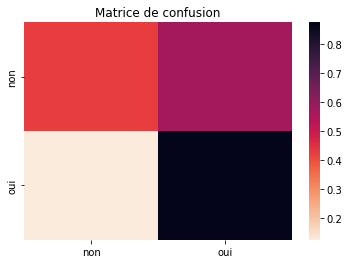

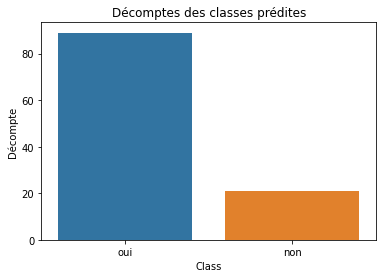

In [287]:
## Analyse des erreurs

def analyze_preds(preds, labels):
  confusion_matrix = sklearn.metrics.confusion_matrix(preds,
                                                      labels,
                                                      normalize="true")
  seaborn.heatmap(confusion_matrix,
                  cmap="rocket_r",
                  xticklabels=label_names,
                  yticklabels=label_names)
  plt.title("Matrice de confusion")
  plt.show()

  seaborn.countplot(x=list(map(lambda x: label_names[x], preds)))
  plt.title("Décomptes des classes prédites")
  plt.ylabel("Décompte")
  plt.xlabel("Class")
  plt.show()


test_pred = np.argmax(model4.predict(np.array(test_images)), axis=-1)
analyze_preds(test_pred, test_labels)

# CONCLUSION

In [288]:
print("Précision du modèle Bords :")
model.evaluate(np.array(test_images), np.array(test_labels), verbose=1)


print("\nPrécision du modèle Phyllotaxie :")
model2.evaluate(np.array(test_images), np.array(test_labels), verbose=1)


print("\nPrécision du modèle Type de feuille :")
model3.evaluate(np.array(test_images), np.array(test_labels), verbose=1)


print("\nPrécision du modèle Ligneux :")
model4.evaluate(np.array(test_images), np.array(test_labels), verbose=1)

Précision du modèle Bords :
4/4 [==============================] - 0s 5ms/step - loss: 8.3269 - accuracy: 0.7727

Précision du modèle Phyllotaxie :
4/4 [==============================] - 0s 5ms/step - loss: 5.5632 - accuracy: 0.6545

Précision du modèle Type de feuille :
4/4 [==============================] - 0s 5ms/step - loss: 6.7387 - accuracy: 0.7000

Précision du modèle Ligneux :
4/4 [==============================] - 0s 5ms/step - loss: 3.7777 - accuracy: 0.7909


[3.777672052383423, 0.7909091114997864]